# Amplitude modulation methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from numpy.fft import fft, ifft, ifft2, rfft, rfftfreq, fft2, ifftn, irfft
import matplotlib.animation as animation
from celluloid import Camera
import os
from scipy import interpolate
import glob as glob
import pickle 
from IPython.display import HTML
from tqdm import tqdm

For the AM we will try to use the following configuration.

Reminder (must be 0 to get zero phase signal) 1.0
Sampling frequency: 10000.0 1995


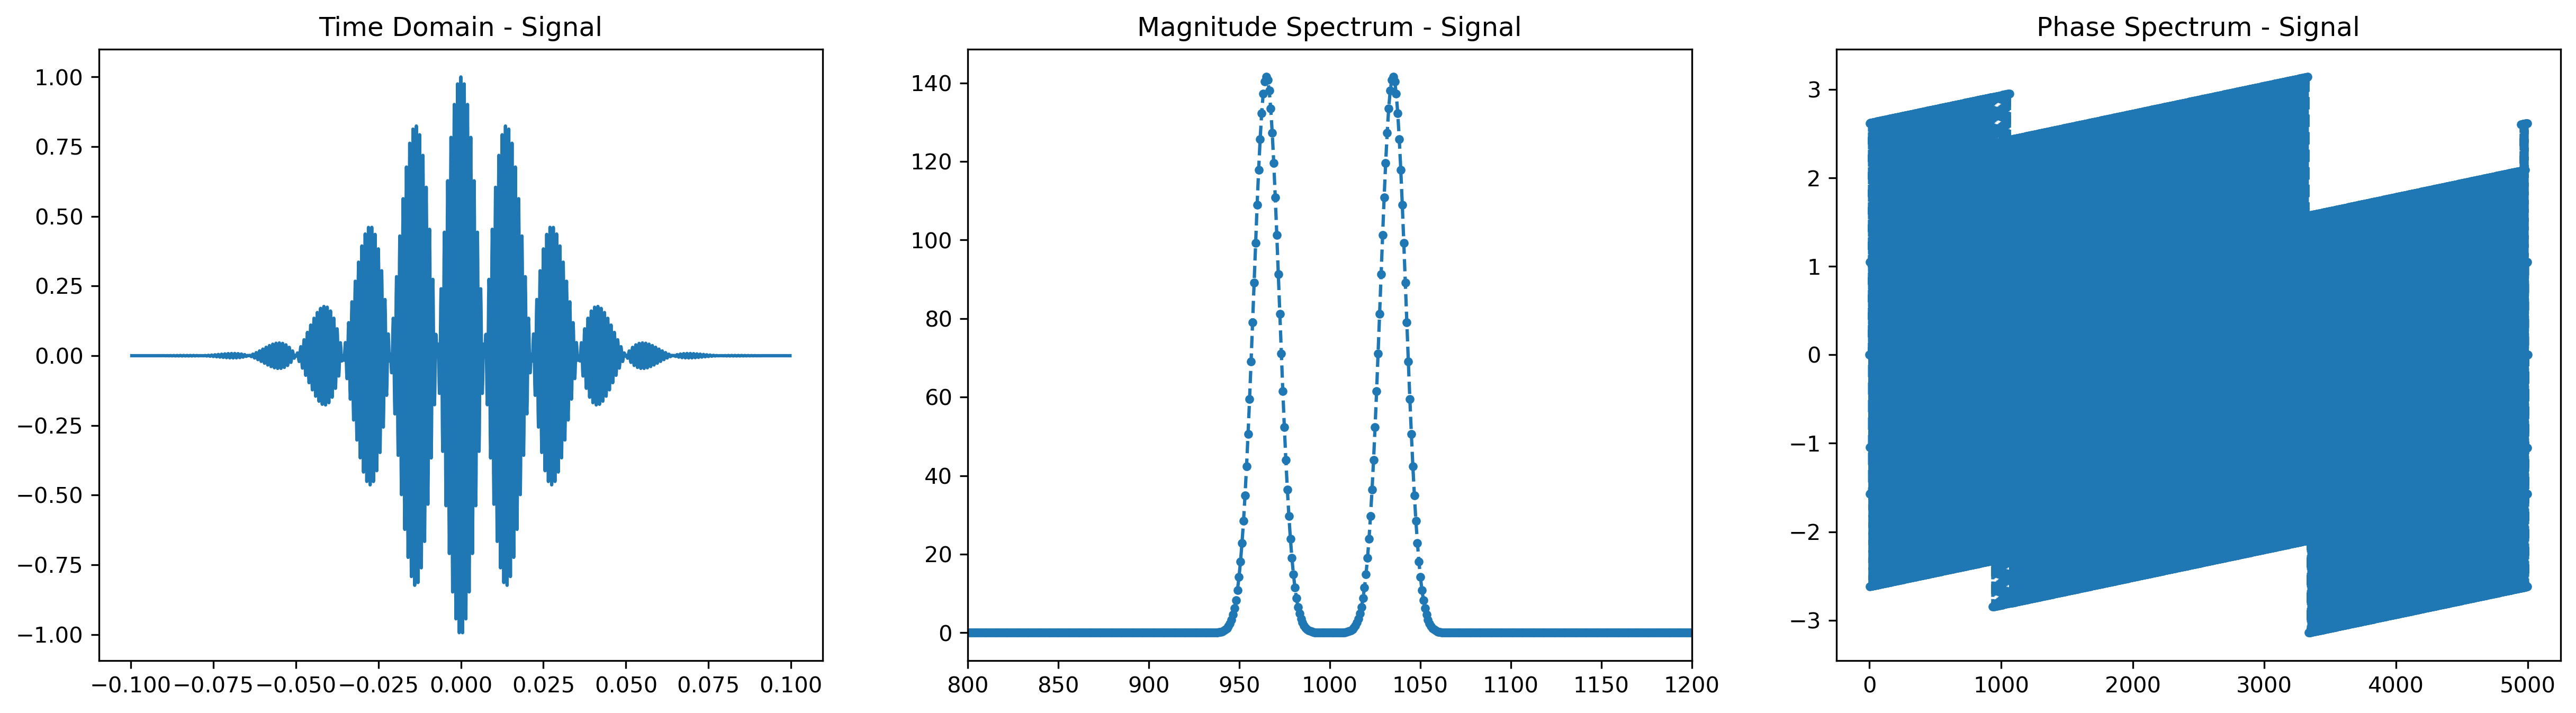

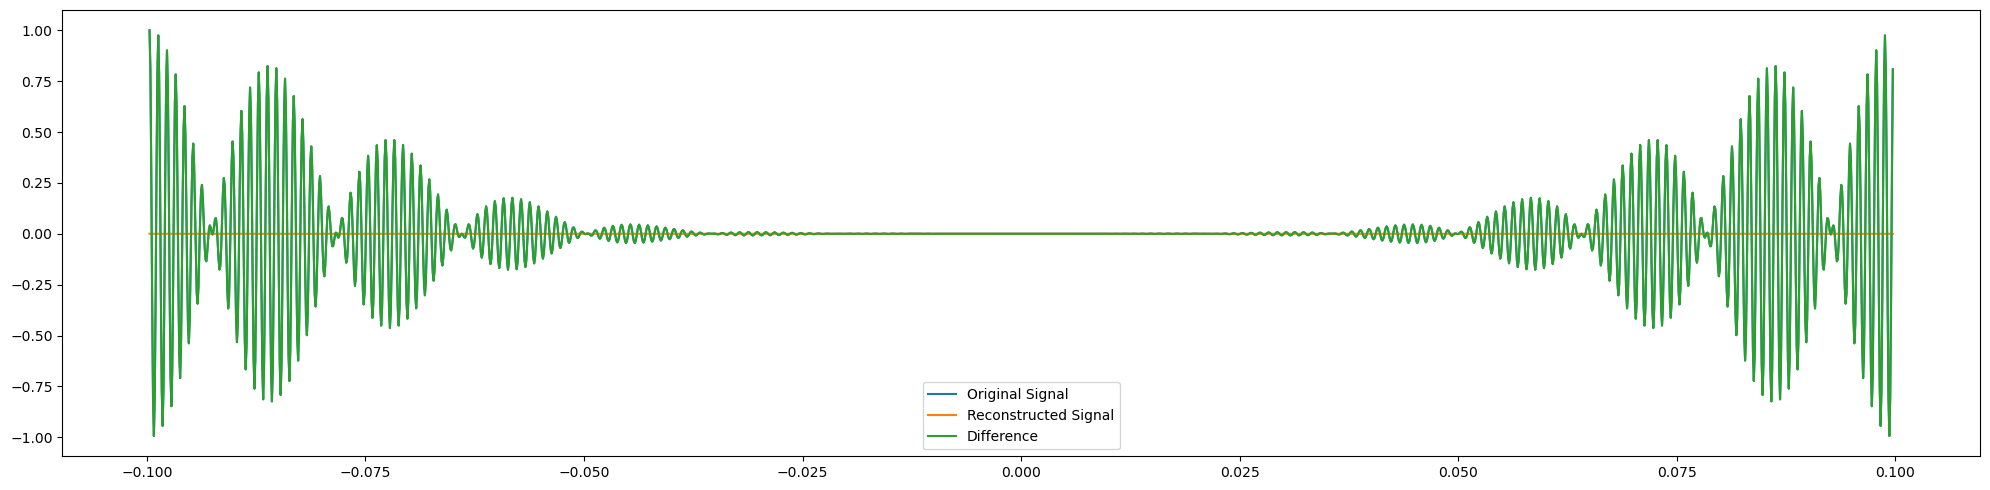

In [2]:
# Frequency setup
fc = 1000
fmod = 35
f1 = fc
f2 = fmod + fc

# Time domain setup
dt = 0.0001
nt = 7*int(1/(fmod*dt)) # multiple of number of samples per cycle of fmod modulating signal
print('Reminder (must be 0 to get zero phase signal)', 1/(f1*dt)- int(1/(f2*dt)))
t = np.arange(nt) * dt 
t -= t[nt//2]
print('Sampling frequency:', 1/dt, nt)

# Generate the DSB-SC signal
agauss = 9.8e2
carrier = np.cos(2*np.pi*(fc)*t) * np.cos(2*np.pi*(fmod)*t)
gaussian = np.exp(-agauss*t**2)
signal = carrier * gaussian

# Zero padding of 5 times the original signal length
zero_padded_signal = np.concatenate((signal, np.zeros(5 * len(signal))))

# Extend time array to match the zero-padded signal
t_extended = np.concatenate((t, t[-1] + np.arange(1, 5 * len(t) + 1) * dt))

# FFT of the signal
SIGNAL = np.fft.rfft(np.fft.ifftshift(zero_padded_signal))
f = np.fft.rfftfreq(len(zero_padded_signal), dt)  # Adjust the frequency range based on the new signal length

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5), dpi=300)

# Plot the time domain signal
#axs[0].plot(t_extended, zero_padded_signal)
axs[0].plot(t, signal)
axs[0].set_title('Time Domain - Signal')

# Plot the magnitude spectrum
axs[1].plot(f, np.abs(SIGNAL), '--.')
axs[1].set_title('Magnitude Spectrum - Signal')
axs[1].set_xlim(f1-fc//5, f1+fc//5)
#axs[1].set_ylim(0, 1e-3)

# Plot the phase spectrum
axs[2].plot(f, np.angle(SIGNAL), '--.')
axs[2].set_title('Phase Spectrum - Signal')

# Reconstruction and error analysis
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(t, np.fft.ifftshift(signal), label='Original Signal')
ax.plot(t, np.fft.irfft(np.abs(SIGNAL), n=len(t)), label='Reconstructed Signal')
ax.plot(t, np.fft.ifftshift(signal)- np.fft.irfft(np.abs(SIGNAL), n=len(t)), label='Difference')
ax.legend()

# Show plots
plt.tight_layout()
plt.show()

In [3]:
print(f'Suggested radius = {np.sqrt(40*1500/fc)}')

Suggested radius = 7.745966692414834


In [4]:
depth_focus = 40

xmin = -20
xmax = 20
ymin = 0
ymax = 0
zmin = 0.0
zmtx = 0.01
zmax = 100
nx = 160 # 80
nz = 400 # 200
dx = (xmax - xmin) / nx
dz = (zmax - zmin) / nz

print(dx, dz)

0.25 0.25


## Continuous to transient using fourier

To determine the non-zero frequencies needed for fourier estimation we do:

In [5]:
#print(f[(_ix := np.where(np.abs(SIGNAL) > 1e-1))])

print('[', end='')

for _i, fr in zip(range(len(f)), f[(_ix := np.where(np.abs(SIGNAL) > 1e-3))]):
    
    if (_i % 4 == 0) and _i > 0:
        print(f'{fr}  ... \n', end='')
                   
    else:
        print(f'{fr}  ', end='')
    
print(']', end='')

[901.4202172096908  906.4327485380117  907.2681704260651  911.4452798663325  912.2807017543859  ... 
916.4578111946532  917.2932330827067  920.6349206349206  921.4703425229741  ... 
922.3057644110276  925.6474519632413  926.4828738512948  927.3182957393483  ... 
929.8245614035087  930.6599832915622  931.4954051796157  932.3308270676691  ... 
933.1662489557226  934.0016708437761  934.8370927318296  935.672514619883  ... 
936.5079365079365  937.3433583959899  938.1787802840433  939.0142021720968  ... 
939.8496240601503  940.6850459482038  941.5204678362572  942.3558897243107  ... 
943.1913116123642  944.0267335004177  944.8621553884711  945.6975772765246  ... 
946.5329991645781  947.3684210526316  948.203842940685  949.0392648287385  ... 
949.8746867167919  950.7101086048453  951.5455304928988  952.3809523809523  ... 
953.2163742690058  954.0517961570592  954.8872180451127  955.7226399331662  ... 
956.5580618212197  957.3934837092731  958.2289055973266  959.0643274853801  ... 
959.899749

In [6]:
list_pres = {}

# Gather all .mat files
files = glob.glob('../fixwav_dx025/*.mat')

# Custom sorting function to sort based on the integer part of filename
files = sorted(files, key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))

for i, file in zip(np.where(np.abs(SIGNAL) > 1e-3)[0], files):
    mat = loadmat(file)
    list_pres[i] = np.squeeze(mat['pressure'])

In [7]:
files

['../fixwav_dx025/1.mat',
 '../fixwav_dx025/2.mat',
 '../fixwav_dx025/3.mat',
 '../fixwav_dx025/4.mat',
 '../fixwav_dx025/5.mat',
 '../fixwav_dx025/6.mat',
 '../fixwav_dx025/7.mat',
 '../fixwav_dx025/8.mat',
 '../fixwav_dx025/9.mat',
 '../fixwav_dx025/10.mat',
 '../fixwav_dx025/11.mat',
 '../fixwav_dx025/12.mat',
 '../fixwav_dx025/13.mat',
 '../fixwav_dx025/14.mat',
 '../fixwav_dx025/15.mat',
 '../fixwav_dx025/16.mat',
 '../fixwav_dx025/17.mat',
 '../fixwav_dx025/18.mat',
 '../fixwav_dx025/19.mat',
 '../fixwav_dx025/20.mat',
 '../fixwav_dx025/21.mat',
 '../fixwav_dx025/22.mat',
 '../fixwav_dx025/23.mat',
 '../fixwav_dx025/24.mat',
 '../fixwav_dx025/25.mat',
 '../fixwav_dx025/26.mat',
 '../fixwav_dx025/27.mat',
 '../fixwav_dx025/28.mat',
 '../fixwav_dx025/29.mat',
 '../fixwav_dx025/30.mat',
 '../fixwav_dx025/31.mat',
 '../fixwav_dx025/32.mat',
 '../fixwav_dx025/33.mat',
 '../fixwav_dx025/34.mat',
 '../fixwav_dx025/35.mat',
 '../fixwav_dx025/36.mat',
 '../fixwav_dx025/37.mat',
 '../fixwa

In [8]:
_ix

(array([1079, 1085, 1086, 1091, 1092, 1097, 1098, 1102, 1103, 1104, 1108,
        1109, 1110, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121,
        1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132,
        1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143,
        1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154,
        1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165,
        1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176,
        1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187,
        1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198,
        1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209,
        1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220,
        1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231,
        1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242,
        1243, 1244, 1245, 1246, 1247, 

The amplitude and phase of the acoustic pressure can be extracted from the complex pressure field as:

\begin{equation}
B (x) = \sqrt{\text{Re} \{ p(x, t) \}^2 + \text{Im} \{ p(x, t) \}^2 }
\end{equation}

\begin{equation}
\theta (x) = \arctan{\frac{\text{Re} \{ p(x, t) \}}{\text{Im} \{ p(x, t) \}}}
\end{equation}

/tmp/ipykernel_15109/3378609519.py:15: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(a)


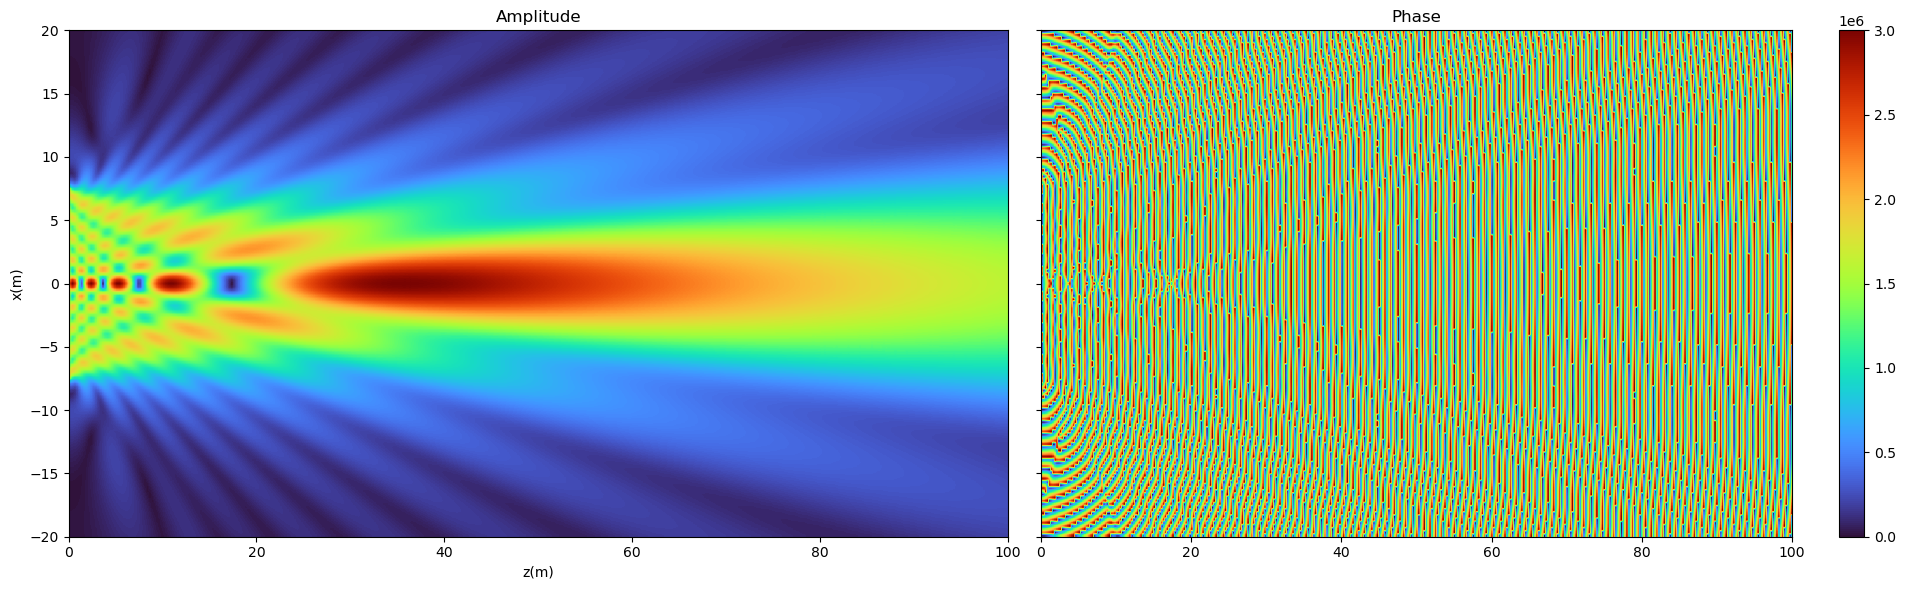

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)


a = axs[0].imshow(abs(list_pres[_ix[0][0]]), cmap='turbo',
                  extent=(zmin, zmax, xmax, xmin), aspect='auto',
                  vmin=0, vmax=3e6)
axs[0].set_ylim(xmin, xmax)
axs[0].set(xlabel='z(m)', ylabel='x(m)')

axs[1].imshow(np.arctan(list_pres[_ix[0][0]].real/list_pres[_ix[0][0]].imag), cmap='turbo', extent=(zmin, zmax, xmax, xmin), aspect='auto')

axs[0].set(title='Amplitude')
axs[1].set(title='Phase')

plt.colorbar(a)

plt.tight_layout()

In [13]:
SIGNAL.max(), abs(list_pres[_ix[0][0]]).max(), 

((126.48912266983606+42.53503356844145j), 2999346.702952995)

In [11]:
pres_shape = list_pres[_ix[0][0]].shape
freq_arr = np.zeros([*pres_shape[:2], len(f)], dtype = list_pres[_ix[0][0]].dtype)

for i in tqdm(range(len(f))):
    try:
        pres = list_pres[i]
        arr_fft = pres * np.abs(SIGNAL[i])
        #arr_fft = np.expand_dims(arr_fft, axis=2)

        # Populate the pre-allocated array
        freq_arr[:, :, i] = arr_fft

    except KeyError:
        # Populate with zeros if a KeyError occurs
        pass

100%|██████████| 5986/5986 [00:01<00:00, 5014.08it/s]


In [12]:
time_arr = irfft(freq_arr, axis=-1)
time_arr = np.concatenate([time_arr[:, :, time_arr.shape[2]//2:], time_arr[:, :, :time_arr.shape[2]//2]], axis=-1)

In [13]:
_ax = np.where(abs(time_arr[nx//2, 100, :])>1e3)[0][0]
_ax
wav_axis = range(_ax-250, np.int64(_ax + 1.7*nt))

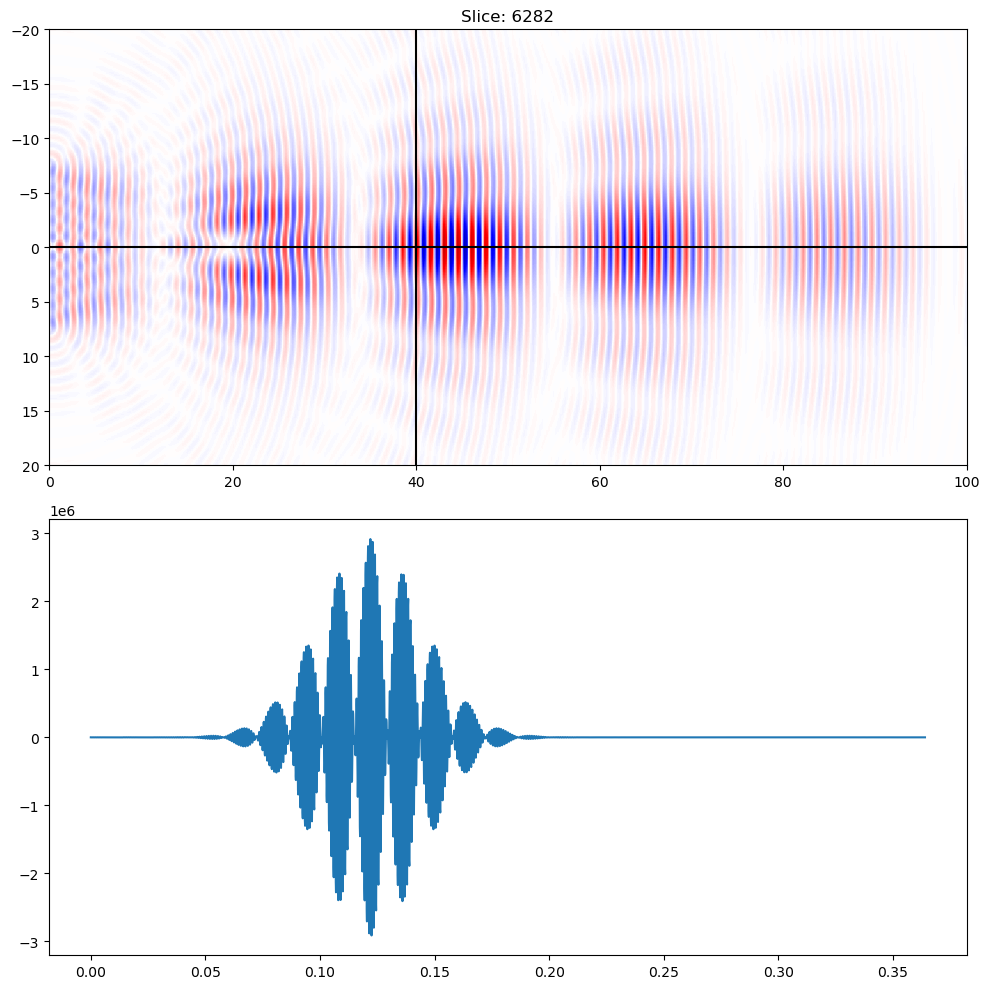

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

i = _ax + 1000
t = np.arange(len(wav_axis)) * dt

axs[0].imshow(time_arr[:, :, i], cmap='seismic', vmax=4e6, vmin=-4e6, extent=(zmin, zmax, xmax, xmin), aspect='auto')
axs[0].axhline(0, c='k')
axs[0].axvline(depth_focus, c='k')

axs[1].plot(t, p := time_arr[nx//2, int(depth_focus/dz), wav_axis])

axs[0].set_title(f'Slice: {i}')  # Set a dynamic title on the first subplot
plt.tight_layout()


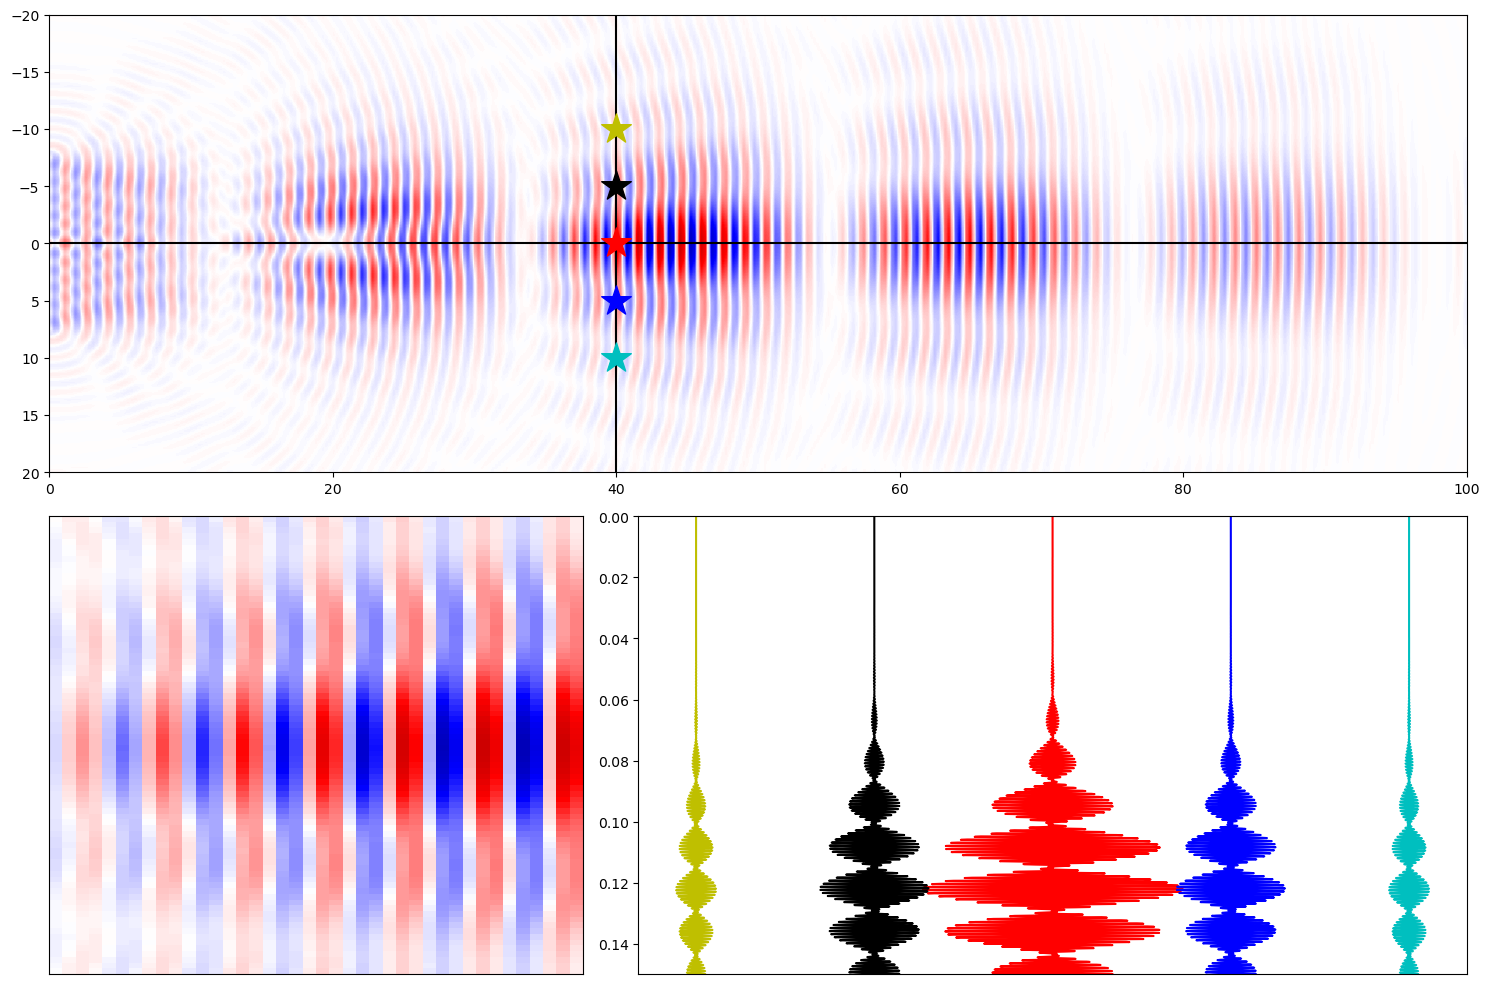

In [15]:
fig, axs = plt.subplot_mosaic('''
AAAAA
BBCCC
''', figsize = (15, 10), sharey=False)

axs['A'].imshow(time_arr[:, :, i], cmap='seismic', vmax=4e6, vmin=-4e6, extent=(zmin, zmax, xmax, xmin), aspect='auto')
axs['A'].axhline(0, c='k')
axs['A'].axvline(depth_focus, c='k')
axs['A'].scatter(depth_focus, 0, marker = '*', s=500, zorder=100, c='r')
axs['A'].scatter(depth_focus, -5, marker = '*', s=500, zorder=100, c='k')
axs['A'].scatter(depth_focus, 5, marker = '*', s=500, zorder=100, c='b')
axs['A'].scatter(depth_focus, 10, marker = '*', s=500, zorder=100, c='c')
axs['A'].scatter(depth_focus, -10, marker = '*', s=500, zorder=100, c='y')

axs['B'].imshow(time_arr[nx//2-int(10/dx):nx//2+int(10/dx), int(depth_focus/dz)-20:int(depth_focus/dz)+20, i], cmap='seismic', vmax=4e6, vmin=-4e6, aspect='auto')
axs['B'].set(xticks=[], yticks=[])

axs['C'].plot(p:= time_arr[nx//2, int(depth_focus/dz), wav_axis], t, c='r')
axs['C'].plot(time_arr[nx//2-int(5/dx), int(depth_focus/dz), wav_axis]-4e6, t, c='k')
axs['C'].plot(time_arr[nx//2+int(5/dx), int(depth_focus/dz), wav_axis]+4e6, t, c='b')
axs['C'].plot(time_arr[nx//2+int(10/dx), int(depth_focus/dz), wav_axis]+8e6, t, c='c')
axs['C'].plot(time_arr[nx//2-int(10/dx), int(depth_focus/dz), wav_axis]-8e6, t, c='y')
axs['C'].set_xticks([])

axs['C'].set_ylim(0, 0.15)
axs['C'].invert_yaxis()

plt.tight_layout()

In [83]:
dif_sources = {}  # Key: Z, X; Value: Trace
for i in np.arange(-10, 10.25, 0.25):
    dif_sources[depth_focus, i] = time_arr[nx//2-int(i/dx), int(depth_focus/dz), wav_axis]

dif_sources

{(40,
  -10.0): array([-57.93272131, -85.37342846, -79.49036426, ...,  11.66995528,
          3.3820764 ,  -6.15612547]),
 (40,
  -9.75): array([-46.90039726, -81.50068615, -85.23874226, ...,  -3.49967798,
         -5.60652474,  -5.43913989]),
 (40,
  -9.5): array([-43.30991607, -87.43812945, -99.18288133, ...,  -6.31932597,
        -13.53678582, -15.23760366]),
 (40,
  -9.25): array([-2.88285157e+01, -7.54729983e+01, -9.42361619e+01, ...,
         3.86852520e+00,  6.81370806e-03, -3.91641588e+00]),
 (40,
  -9.0): array([ -35.73141808, -101.58238748, -129.16320659, ...,   -8.59137501,
          -6.33342146,   -1.54376381]),
 (40,
  -8.75): array([ 9.38047689e-02, -7.30272637e+01, -1.18410864e+02, ...,
         1.02892751e+01,  1.62031173e+01,  1.58643744e+01]),
 (40,
  -8.5): array([  13.42232639,  -71.17291662, -129.55703439, ...,    1.19759876,
          10.49142708,   15.84971934]),
 (40,
  -8.25): array([  22.1279318 ,  -65.39227459, -129.01172647, ...,   18.06493707,
          11.

In [84]:
with open('sources_array.pkl', 'wb') as f:
    pickle.dump([dif_sources, t], f)

In [20]:
# Integration setup
T = 40
integration_res = []
time_points = []

for ix in range(T//2, len(t) - T//2, T):
    integ = np.sum(p[ix-T//2:ix+T//2]**2) * dt
    integ *= 1/(1900 * 100)
    integration_res.append(integ/(T*dt))
    time_points.append(t[ix])

# Interpolation of the integration result
f = interpolate.interp1d(np.array(time_points), np.array(integration_res), bounds_error=False, fill_value=0, kind='cubic')
integ_dense = f(t)

From Maleke (2010) we define the magnitude of the force as: 
\begin{equation}
F(t) = \frac{2 \alpha I(t)}{c} 
\end{equation}

with 
\begin{equation}
I(t) = \frac{1}{T} \int_{t-T/2}^{t+T/2}{\frac{p^2(t)}{\rho c}}
\end{equation}

Where $p$ is given in Pascals (Pa) (from FOCUS), the density of seawater is around 1025 $Kg/m^3$, the velocity of sound in water is 1481 $m/s$ and the alpha for the seawater taken from previous results is 

$$\text{absorption (1/m)} = \text{absorption (dB/cm)} \times 100 \times \log_{10}(e)$$
$$\text{absorption (1/m)} = 4\times 10^{-7} (dB/cm) \times 100 \times \log_{10}(e) = 1.737 \times 10^{-5}$$

[Text(0, 0.5, '$N/m^3$'), Text(0.5, 1.0, '$ARF$')]

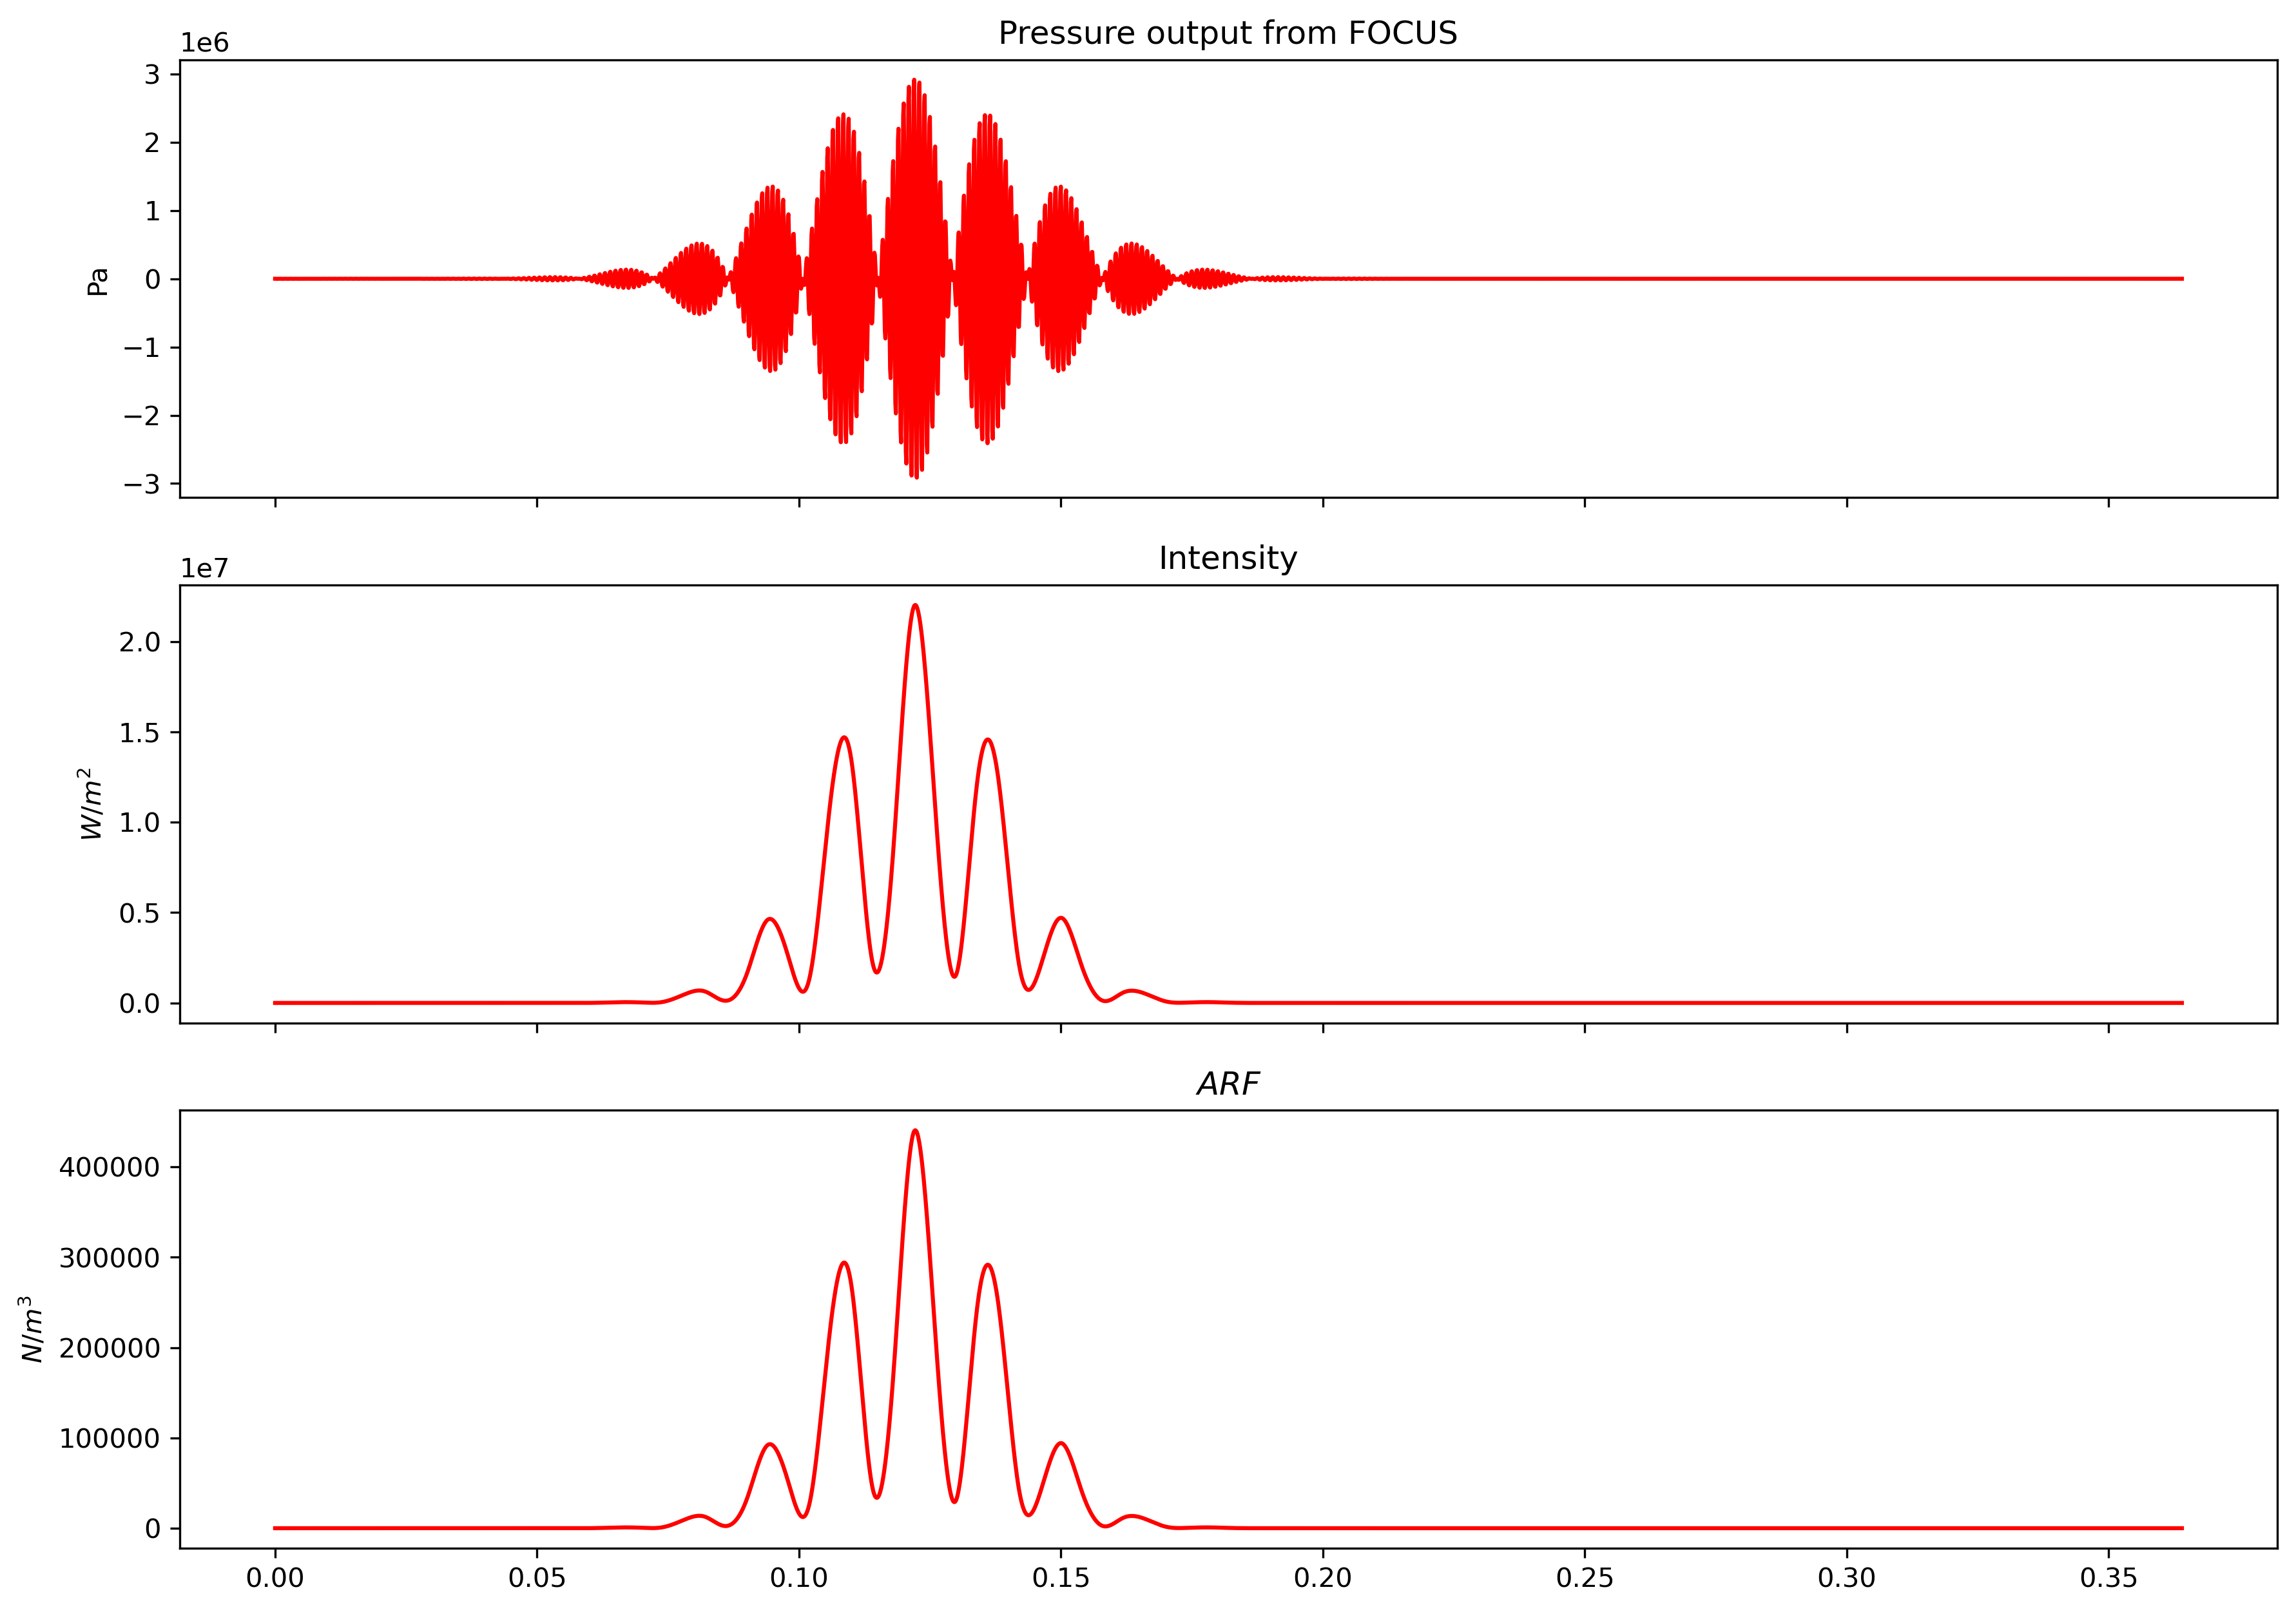

In [25]:
force = (2 * 1 * integ_dense)/100

fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True, dpi=300)

axs[0].plot(t, p, c='r', label='$p(t)$')
axs[0].set(ylabel='Pa', title='Pressure output from FOCUS')

axs[1].plot(t, integ_dense, c='r', label='$p^2(t)$')
axs[1].set(ylabel='$W/m^2$', title='Intensity')

axs[2].plot(t, force,  c='r',label='$ARF$')
axs[2].set(ylabel='$N/m^3$', title='$ARF$')

# axs[0].set(xlim=[0, 0.01], ylim=[-10000, 10000])
# axs[1].set(xlim=[0, 0.01], ylim=[-5000000, 5000000])
# axs[2].set(xlim=[0, 0.01], ylim=[0, 4e-8])

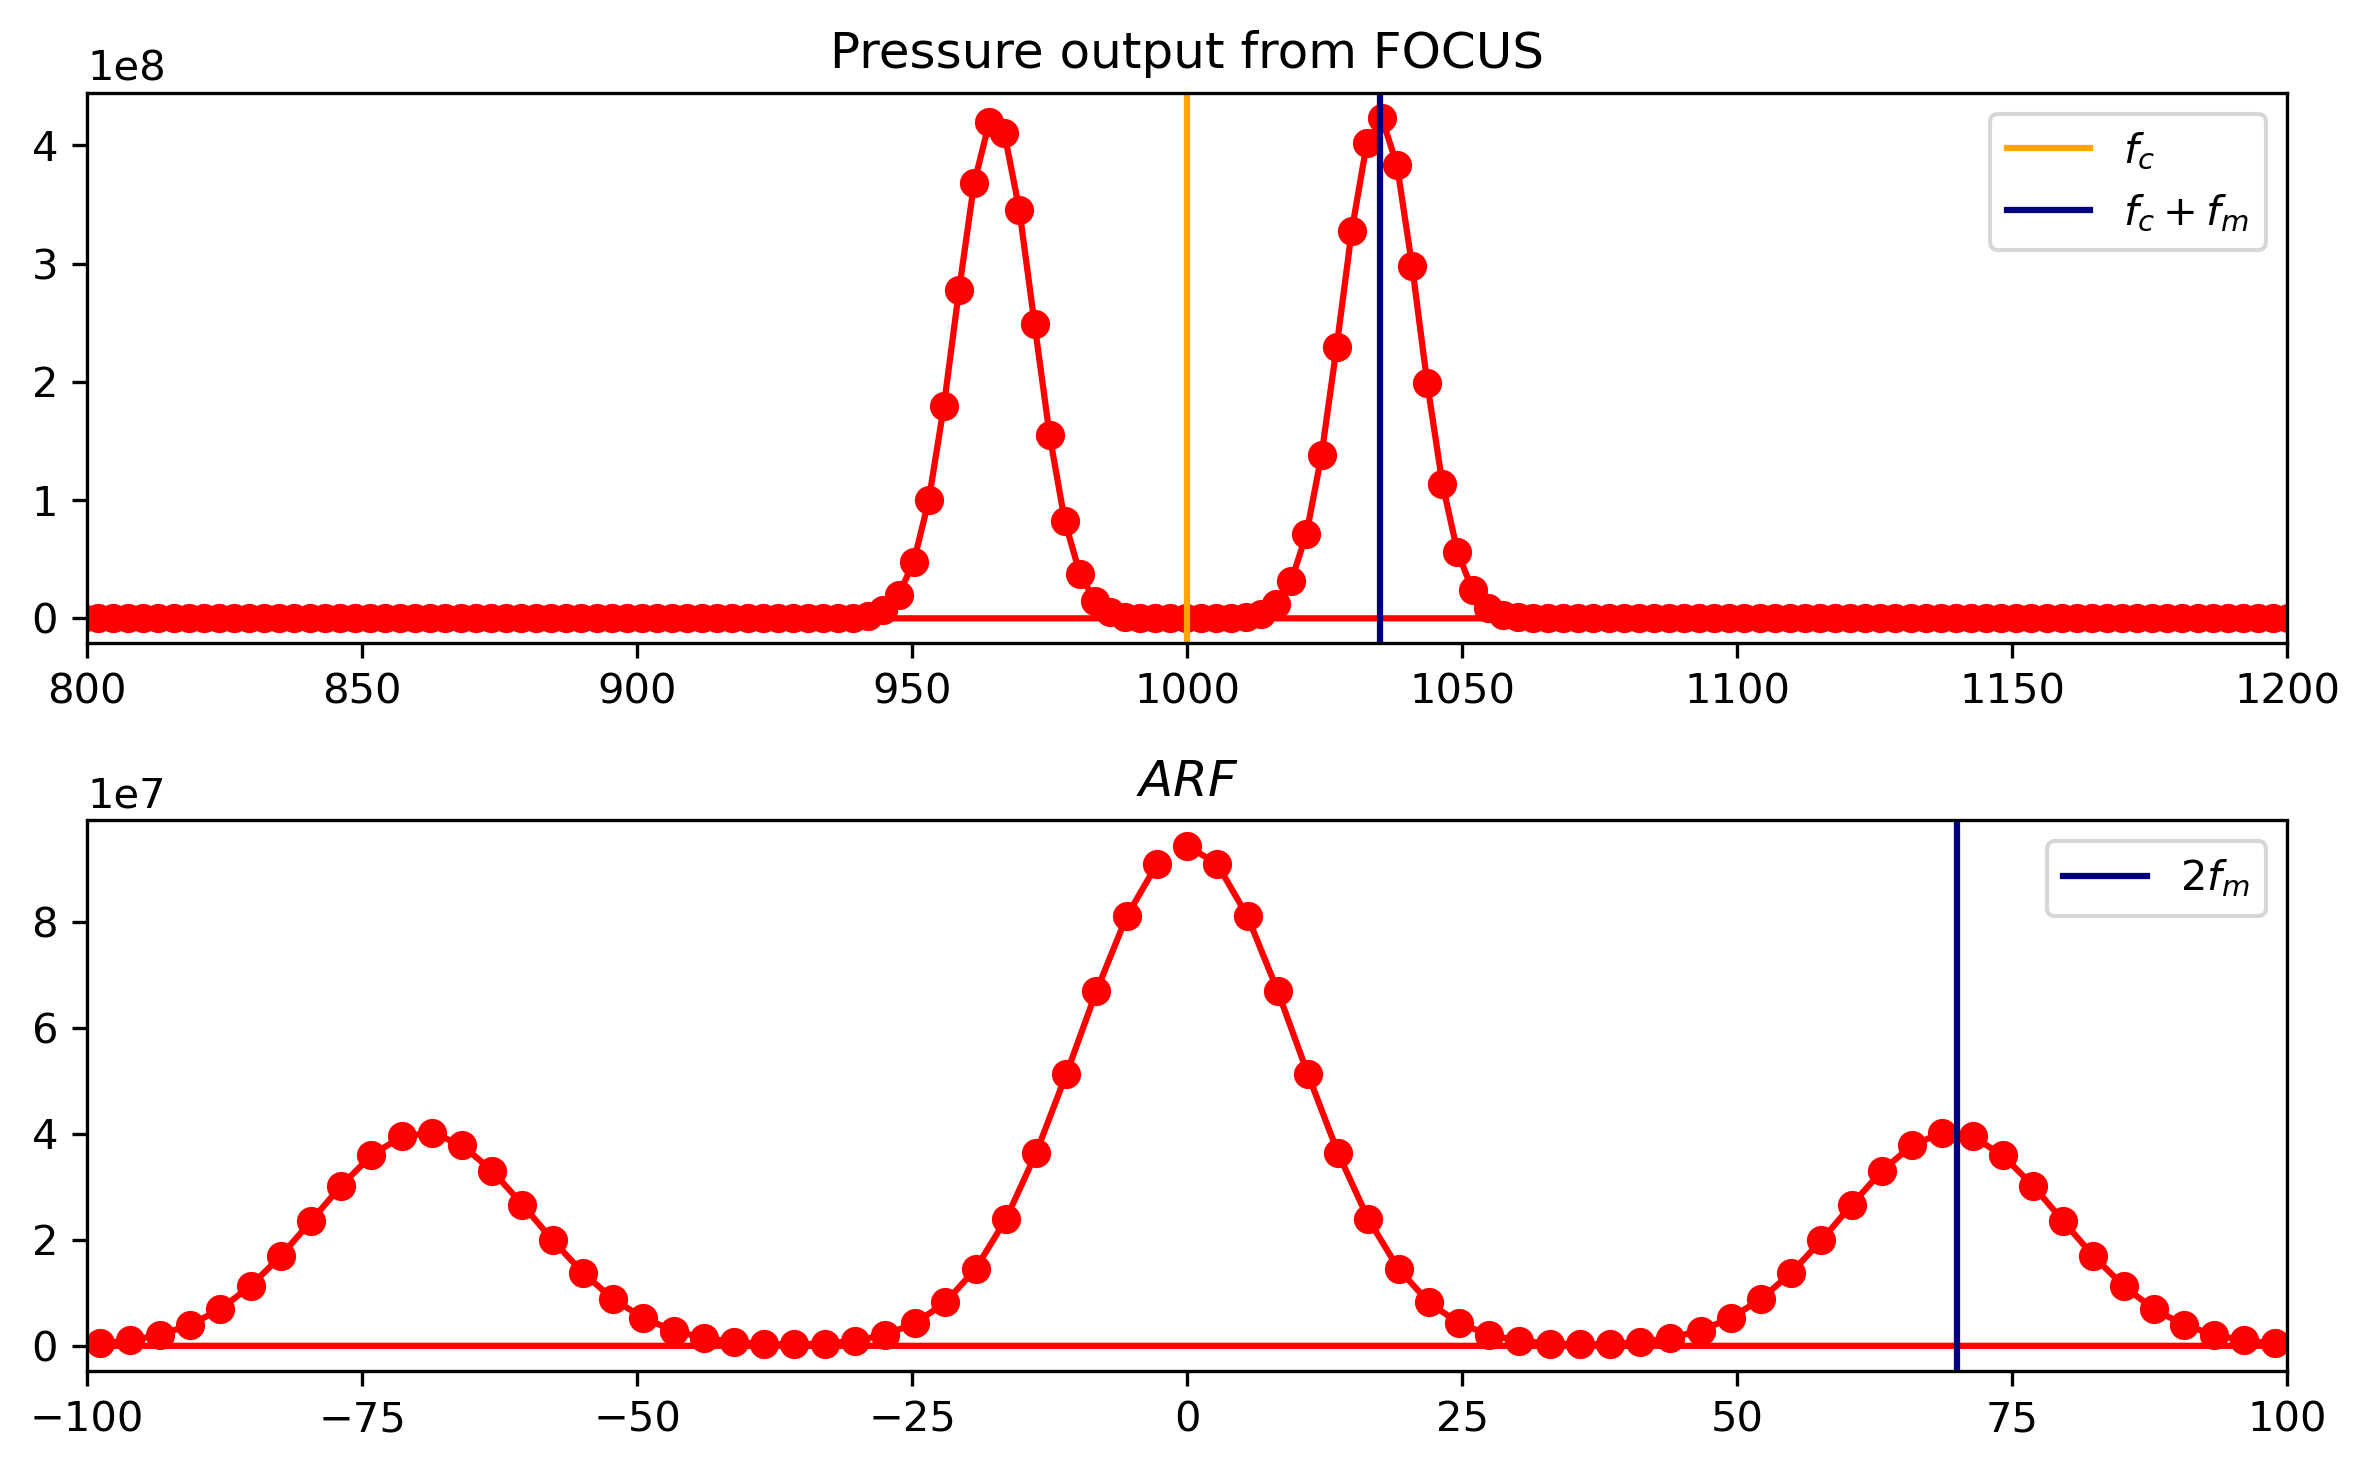

In [44]:
# Compute the FFT of the signals
fft_p = fft(p)
fft_p2 = fft(p**2)
fft_arf = fft(force)

# Compute the frequency bins
freq_p = np.fft.fftfreq(len(p), dt)
freq_p2 = np.fft.fftfreq(len(p), dt)
freq_force = np.fft.fftfreq(len(force), dt)

fig, axs = plt.subplots(2, 1, figsize=(8, 5), dpi=300)

axs[0].plot(freq_p, np.abs(fft_p), 'o-', c='r')
axs[0].axvline(1000, label='$f_c$', c='orange')
axs[0].axvline(1035, label='$f_c + f_m$', c='navy')
axs[0].set(title='Pressure output from FOCUS', xlim=[800, 1200])

axs[1].plot(freq_force, np.abs(fft_arf), 'o-',  c='r')
axs[1].set(title='$ARF$', xlim=[-100, 100])
axs[1].axvline(70, label='$2f_m$', c='navy')

axs[1].legend()
axs[0].legend()
plt.tight_layout();

## To make video

  0%|          | 0/3641 [00:00<?, ?it/s]

100%|██████████| 3641/3641 [50:22<00:00,  1.20it/s]


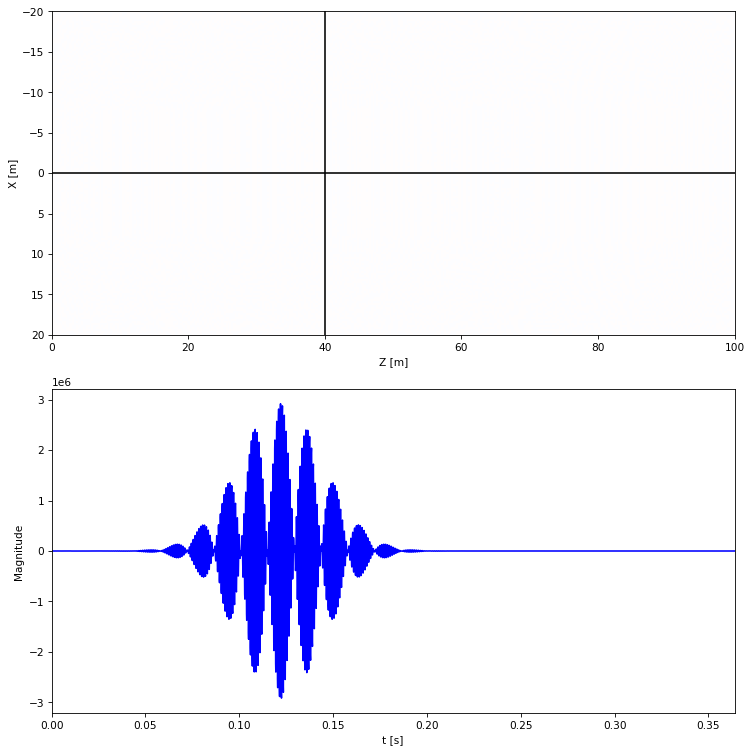

In [71]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10), dpi=76)

camera = Camera(fig)

t = np.arange(len(wav_axis)) * dt

for i in tqdm(wav_axis[::1]):
    
    axs[0].imshow(time_arr[:, :, i], cmap='seismic', vmax=1e6, vmin=-1e6, extent=(zmin, zmax, xmax, xmin), aspect='auto', interpolation='nearest')
    axs[0].axhline(0, c='k')
    axs[0].axvline(depth_focus, c='k')

    axs[1].plot(t[:i-wav_axis[0]], time_arr[nx//2, int(depth_focus/dz), wav_axis[0]:i], c='b')
    
    axs[0].set(xlabel='Z [m]', ylabel='X [m]')
    axs[1].set(xlabel='t [s]', ylabel='Magnitude', xlim=(t[0], t[-1]))

    plt.tight_layout()
    camera.snap()

animation = camera.animate(interval = 5)
animation.save('exp1_wa.mp4')